Vamos tentar outras estrategias do modelo já que na v1 correu mal

In [1]:
import pandas as pd
import numpy as np


# Lista final de features que o modelo treinado espera, NA ORDEM CORRETA.
# Esta lista foi definida no final da sua EDA.
FEATURES_FINAIS_PARA_MODELO = [
    'total_issues_created_log',
    'issue_participation_log',
    'issue_resolution_rate_created_log',
    'total_review_activity_log',
    'merged_ratio_log',
    'sum_lines_added_log',
    'interval',
    'branches_created',
]

# Epsilon para evitar divisão por zero nos ratios
EPSILON = 1e-6

# Colunas a serem removidas inicialmente se existirem
COLS_TO_DROP_INITIAL = [
    "project_id",
    "group_id",
    "mention_handle",
    "last_minute_commits", # Foi identificada como sempre zero
    "sum_lines_per_commit" # Foi removida devido à alta correlação/redundância
]

In [3]:
# ==============================================================================
# FUNÇÃO DE PRÉ-PROCESSAMENTO
# ==============================================================================

def preprocess_data_for_prediction(df_new_raw):
    df_processed = df_new_raw.copy()
    print(f"Pré-processamento: Dimensões iniciais dos novos dados: {df_processed.shape}")

    # --- 1. Remover colunas irrelevantes ---
    print("Pré-processamento: Removendo colunas irrelevantes...")
    for col in COLS_TO_DROP_INITIAL:
        if col in df_processed.columns:
            df_processed.drop(columns=[col], inplace=True)
            print(f"  Coluna '{col}' removida.")
    print(f"Pré-processamento: Dimensões após remoção inicial: {df_processed.shape}")


    # --- 2. Criar features _log diretamente necessárias para o modelo ---
    # (Estas são features que entram no modelo como _log e não são derivadas de ratios complexos)
    print("Pré-processamento: Criando features _log diretas...")

    # sum_lines_added_log
    if 'sum_lines_added' in df_processed.columns:
        df_processed['sum_lines_added_log'] = np.log1p(df_processed['sum_lines_added'])
        print("  Feature 'sum_lines_added_log' criada.")
    else:
        print("  AVISO: Coluna 'sum_lines_added' não encontrada. 'sum_lines_added_log' não será criada diretamente aqui (será preenchida no final se faltar).")

    # total_issues_created_log
    if 'total_issues_created' in df_processed.columns:
        df_processed['total_issues_created_log'] = np.log1p(df_processed['total_issues_created'])
        print("  Feature 'total_issues_created_log' criada.")
    else:
        print("  AVISO: Coluna 'total_issues_created' não encontrada. 'total_issues_created_log' não será criada diretamente aqui.")

    # issue_participation_log
    if 'issue_participation' in df_processed.columns:
        df_processed['issue_participation_log'] = np.log1p(df_processed['issue_participation'])
        print("  Feature 'issue_participation_log' criada.")
    else:
        print("  AVISO: Coluna 'issue_participation' não encontrada. 'issue_participation_log' não será criada diretamente aqui.")


    # --- 3. Engenharia de Features (Ratios e Combinadas com Log) ---
    print("Pré-processamento: Iniciando engenharia de features (ratios, combinadas)...")

    # Merged Ratio Log
    if 'merged_requests' in df_processed.columns and 'total_merge_requests' in df_processed.columns:
        merged_ratio_raw = df_processed['merged_requests'] / (df_processed['total_merge_requests'] + EPSILON)
        df_processed['merged_ratio_log'] = np.log1p(merged_ratio_raw)
        print("  Feature 'merged_ratio_log' criada.")
    else:
        print("  AVISO: Colunas 'merged_requests' ou 'total_merge_requests' não encontradas. 'merged_ratio_log' não será criada (será preenchida no final se faltar).")
        df_processed['merged_ratio_log'] = np.log1p(0) # Preenchimento padrão se faltar

    # Issue Resolution Rate Created Log
    if 'issues_resolved' in df_processed.columns and 'total_issues_created' in df_processed.columns:
        issue_res_rate_created_raw = df_processed['issues_resolved'] / (df_processed['total_issues_created'] + EPSILON)
        df_processed['issue_resolution_rate_created_log'] = np.log1p(issue_res_rate_created_raw)
        print("  Feature 'issue_resolution_rate_created_log' criada.")
    else:
        print("  AVISO: Colunas 'issues_resolved' ou 'total_issues_created' não encontradas. 'issue_resolution_rate_created_log' não será criada (será preenchida no final se faltar).")
        df_processed['issue_resolution_rate_created_log'] = np.log1p(0) # Preenchimento padrão

    # Total Review Activity Log
    if 'review_comments_given' in df_processed.columns and 'review_comments_received' in df_processed.columns:
        total_review_raw = df_processed['review_comments_given'] + df_processed['review_comments_received']
        df_processed['total_review_activity_log'] = np.log1p(total_review_raw)
        print("  Feature 'total_review_activity_log' criada.")
    else:
        print("  AVISO: Colunas 'review_comments_given' ou 'review_comments_received' não encontradas. 'total_review_activity_log' não será criada (será preenchida no final se faltar).")
        df_processed['total_review_activity_log'] = np.log1p(0) # Preenchimento padrão

    # --- 4. Garantir que todas as features finais estão presentes e selecionar ---
    #    As features 'interval' e 'branches_created' são usadas como estão (se existirem).
    print("Pré-processamento: Selecionando e ordenando features finais...")
    missing_features_in_final_step = []
    for final_feature in FEATURES_FINAIS_PARA_MODELO:
        if final_feature not in df_processed.columns:
            print(f"  AVISO FINAL: Feature final '{final_feature}' não encontrada nos dados processados. Preenchendo com 0.")
            df_processed[final_feature] = 0 # Ou outra estratégia de imputação (ex: média do treino)
            missing_features_in_final_step.append(final_feature)
    
    if missing_features_in_final_step:
        print(f"  Resumo de features finais que foram preenchidas com 0: {missing_features_in_final_step}")

    # Selecionar apenas as colunas finais na ordem correta
    # Adiciona colunas faltantes com 0 se, mesmo após tudo, elas não existirem (caso extremo)
    for col in FEATURES_FINAIS_PARA_MODELO:
        if col not in df_processed:
            df_processed[col] = 0

    df_model_ready = df_processed[FEATURES_FINAIS_PARA_MODELO]
    print(f"Pré-processamento: Dimensões finais dos dados prontos para o modelo (antes do scaler): {df_model_ready.shape}")
    
    return df_model_ready


In [5]:
import pandas as pd

df = pd.read_csv("student_features_interval_all.csv")  # Substitua pelo nome do seu arquivo

In [6]:
X_raw = df.drop(columns=["Final Grade"])  # Features
y = df["Final Grade"]  # Target

In [7]:
X = preprocess_data_for_prediction(X_raw)


Pré-processamento: Dimensões iniciais dos novos dados: (1077, 20)
Pré-processamento: Removendo colunas irrelevantes...
  Coluna 'project_id' removida.
  Coluna 'group_id' removida.
  Coluna 'mention_handle' removida.
  Coluna 'last_minute_commits' removida.
  Coluna 'sum_lines_per_commit' removida.
Pré-processamento: Dimensões após remoção inicial: (1077, 15)
Pré-processamento: Criando features _log diretas...
  Feature 'sum_lines_added_log' criada.
  Feature 'total_issues_created_log' criada.
  Feature 'issue_participation_log' criada.
Pré-processamento: Iniciando engenharia de features (ratios, combinadas)...
  Feature 'merged_ratio_log' criada.
  Feature 'issue_resolution_rate_created_log' criada.
  Feature 'total_review_activity_log' criada.
Pré-processamento: Selecionando e ordenando features finais...
Pré-processamento: Dimensões finais dos dados prontos para o modelo (antes do scaler): (1077, 8)


In [8]:
from sklearn.preprocessing import KBinsDiscretizer

# Estratificação por quantis --> por causa do desbalanceamento
stratifier = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
y_strat = stratifier.fit_transform(y.values.reshape(-1, 1)).ravel()

In [8]:
from sklearn.model_selection import train_test_split

# Dividir em treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y_strat, random_state=42
)

In [9]:
! pip install lightgbm

In [10]:
import lightgbm
print(lightgbm.__version__)

4.6.0


In [11]:
from lightgbm import LGBMRegressor
from lightgbm import early_stopping, log_evaluation

model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

In [12]:
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="mae",
    callbacks=[
        early_stopping(stopping_rounds=30),
        log_evaluation(period=50)
    ]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 429
[LightGBM] [Info] Number of data points in the train set: 861, number of used features: 8
[LightGBM] [Info] Start training from score 13.478513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

c:\Users\cataf\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] O sistema não conseguiu localizar o ficheiro especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\cataf\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\cataf\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\cataf\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\cataf\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor(learning_rate=0.05, max_depth=6, n_estimators=1000,
              random_state=42)

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nDesempenho no conjunto de teste:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


Desempenho no conjunto de teste:
MAE: 1.57
RMSE: 2.24


In [14]:
# só para ver mais ou menos onde esta a errar
from sklearn.metrics import mean_absolute_error

# Definir faixas de notas apenas para análise do erro por região
bins = [0, 9, 13, 16, 18, 20]
labels = ["Muito baixa", "Baixa", "Média", "Alta", "Muito alta"]

# Criar categorias temporárias só para análise
y_test_bins = pd.cut(y_test, bins=bins, labels=labels, right=True)
results_df = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred,
    "faixa": y_test_bins
})

# MAE por faixa (diagnóstico)
mae_por_faixa = results_df.groupby("faixa").apply(lambda g: mean_absolute_error(g["y_true"], g["y_pred"]))
contagem_por_faixa = results_df["faixa"].value_counts().sort_index()

print("\n📊 MAE por faixa de nota:")
print(mae_por_faixa)

print("\n📊 Nº de exemplos por faixa:")
print(contagem_por_faixa)



📊 MAE por faixa de nota:
faixa
Muito baixa    2.976679
Baixa          1.111897
Média          1.590419
Alta           1.668367
Muito alta     2.195413
dtype: float64

📊 Nº de exemplos por faixa:
faixa
Muito baixa     9
Baixa          83
Média          86
Alta           30
Muito alta      4
Name: count, dtype: int64


C:\Users\cataf\AppData\Local\Temp\ipykernel_9932\4143451678.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mae_por_faixa = results_df.groupby("faixa").apply(lambda g: mean_absolute_error(g["y_true"], g["y_pred"]))
C:\Users\cataf\AppData\Local\Temp\ipykernel_9932\4143451678.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_por_faixa = results_df.groupby("faixa").apply(lambda g: mean_absolute_error(g["y_true"], g["y_pred"]))


sample_weight --> Dar mais importância (peso) aos exemplos raros ou difíceis durante o treino do modelo.

In [15]:
# === Criar faixas e pesos ===
bins = [0, 9, 13, 16, 18, 20]
labels = ["Muito baixa", "Baixa", "Média", "Alta", "Muito alta"]
y_train_bins = pd.cut(y_train, bins=bins, labels=labels)

# Define os pesos
pesos_por_faixa = {
    "Muito baixa": 5,
    "Baixa": 1,
    "Média": 1,
    "Alta": 2,
    "Muito alta": 5
}
sample_weights = y_train_bins.map(pesos_por_faixa)

# === Modelo LightGBM com pesos ===
model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

model.fit(
    X_train, y_train,
    sample_weight=sample_weights,
    eval_set=[(X_test, y_test)],
    eval_metric="mae",
    callbacks=[
        early_stopping(stopping_rounds=30),
        log_evaluation(50)
    ]
)

# === Avaliação final ===
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 429
[LightGBM] [Info] Number of data points in the train set: 861, number of used features: 8
[LightGBM] [Info] Start training from score 12.886972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [16]:
print(f"\nDesempenho com sample_weight:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


Desempenho com sample_weight:
MAE: 1.68
RMSE: 2.70


In [17]:
# Assumindo que já tens y_test e y_pred após treino com sample_weight

import pandas as pd
from sklearn.metrics import mean_absolute_error

# Definir faixas
bins = [0, 9, 13, 16, 18, 20]
labels = ["Muito baixa", "Baixa", "Média", "Alta", "Muito alta"]
y_test_bins = pd.cut(y_test, bins=bins, labels=labels)

# Criar DataFrame de resultados
results_df = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred,
    "faixa": y_test_bins
})

# MAE por faixa
mae_por_faixa = results_df.groupby("faixa").apply(
    lambda g: mean_absolute_error(g["y_true"], g["y_pred"])
)
contagem_por_faixa = results_df["faixa"].value_counts().sort_index()

print("--->  MAE por faixa (modelo com sample_weight):")
print(mae_por_faixa)

print("\n---> Nº de exemplos por faixa:")
print(contagem_por_faixa)


C:\Users\cataf\AppData\Local\Temp\ipykernel_9932\1479867575.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mae_por_faixa = results_df.groupby("faixa").apply(


--->  MAE por faixa (modelo com sample_weight):
faixa
Muito baixa    2.902038
Baixa          1.319463
Média          1.454750
Alta           1.519619
Muito alta     1.536708
dtype: float64

---> Nº de exemplos por faixa:
faixa
Muito baixa     9
Baixa          83
Média          86
Alta           30
Muito alta      4
Name: count, dtype: int64


C:\Users\cataf\AppData\Local\Temp\ipykernel_9932\1479867575.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_por_faixa = results_df.groupby("faixa").apply(


melhoraram todos (menos uma pequena diferença no baixa)

In [18]:
import matplotlib.pyplot as plt

# Importância das features
importances = model.feature_importances_
feature_names = X.columns

# Ordenar
indices = np.argsort(importances)[::-1]

for i in indices:
    print(f"{feature_names[i]}: {importances[i]}")

issue_participation_log: 1480
total_review_activity_log: 1443
branches_created: 866
total_issues_created_log: 676
issue_resolution_rate_created_log: 665
merged_ratio_log: 656
interval: 553
sum_lines_added_log: 487


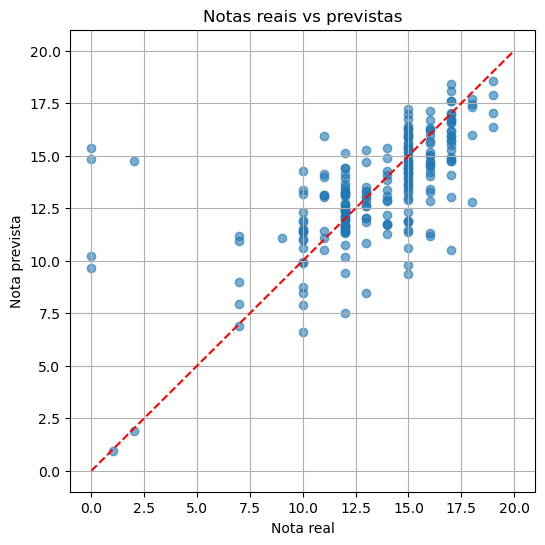

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([0, 20], [0, 20], 'r--')  # Linha ideal
plt.xlabel("Nota real")
plt.ylabel("Nota prevista")
plt.title("Notas reais vs previstas")
plt.grid(True)
plt.show()


vamos tentar com outra afinação

In [20]:
#pesos_por_faixa = {
#    "Muito baixa": 6,
#    "Baixa": 1,
#    "Média": 1,
#    "Alta": 2,
#    "Muito alta": 6
#}

In [21]:
sample_weights = y_train_bins.map(pesos_por_faixa)

# === Modelo LightGBM com pesos ===
model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

model.fit(
    X_train, y_train,
    sample_weight=sample_weights,
    eval_set=[(X_test, y_test)],
    eval_metric="mae",
    callbacks=[
        early_stopping(stopping_rounds=30),
        log_evaluation(50)
    ]
)

# === Avaliação final ===
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 429
[LightGBM] [Info] Number of data points in the train set: 861, number of used features: 8
[LightGBM] [Info] Start training from score 12.886972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [22]:
print(f"\nDesempenho com sample_weight:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


Desempenho com sample_weight:
MAE: 1.68
RMSE: 2.70


In [23]:
# Assumindo que já tens y_test e y_pred após treino com sample_weight

import pandas as pd
from sklearn.metrics import mean_absolute_error

# Definir faixas
bins = [0, 9, 13, 16, 18, 20]
labels = ["Muito baixa", "Baixa", "Média", "Alta", "Muito alta"]
y_test_bins = pd.cut(y_test, bins=bins, labels=labels)

# Criar DataFrame de resultados
results_df = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred,
    "faixa": y_test_bins
})

# MAE por faixa
mae_por_faixa = results_df.groupby("faixa").apply(
    lambda g: mean_absolute_error(g["y_true"], g["y_pred"])
)
contagem_por_faixa = results_df["faixa"].value_counts().sort_index()

print("--->  MAE por faixa (modelo com sample_weight):")
print(mae_por_faixa)

print("\n---> Nº de exemplos por faixa:")
print(contagem_por_faixa)


--->  MAE por faixa (modelo com sample_weight):
faixa
Muito baixa    2.902038
Baixa          1.319463
Média          1.454750
Alta           1.519619
Muito alta     1.536708
dtype: float64

---> Nº de exemplos por faixa:
faixa
Muito baixa     9
Baixa          83
Média          86
Alta           30
Muito alta      4
Name: count, dtype: int64


C:\Users\cataf\AppData\Local\Temp\ipykernel_9932\1479867575.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mae_por_faixa = results_df.groupby("faixa").apply(
C:\Users\cataf\AppData\Local\Temp\ipykernel_9932\1479867575.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_por_faixa = results_df.groupby("faixa").apply(


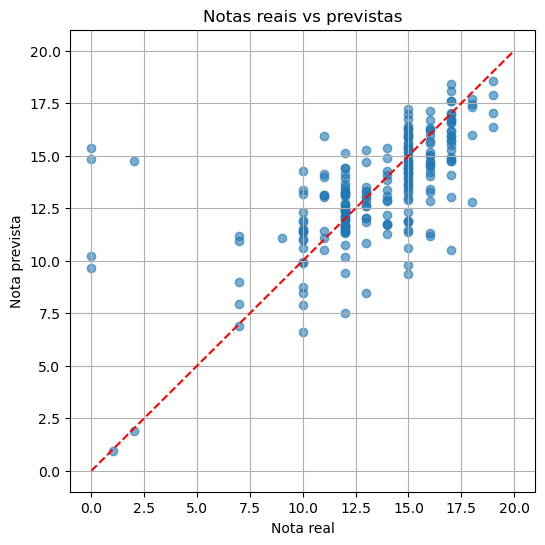

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([0, 20], [0, 20], 'r--')  # Linha ideal
plt.xlabel("Nota real")
plt.ylabel("Nota prevista")
plt.title("Notas reais vs previstas")
plt.grid(True)
plt.show()


nao é que tenha sido má, mas a anterior foi melhor... 

In [25]:
# Dataset completo
df = pd.read_csv("student_features_interval_all.csv")
X_raw = df.drop(columns=["Final Grade"])
y = df["Final Grade"]

# Pré-processamento igual ao modelo geral
X = preprocess_data_for_prediction(X_raw)

# Separar extremos (para treino do modelo especializado)
extremos_mask = (y <= 9) | (y >= 19)
X_extremos = X[extremos_mask]
y_extremos = y[extremos_mask]

print(f"Total de exemplos extremos: {len(y_extremos)}")


Pré-processamento: Dimensões iniciais dos novos dados: (1077, 20)
Pré-processamento: Removendo colunas irrelevantes...
  Coluna 'project_id' removida.
  Coluna 'group_id' removida.
  Coluna 'mention_handle' removida.
  Coluna 'last_minute_commits' removida.
  Coluna 'sum_lines_per_commit' removida.
Pré-processamento: Dimensões após remoção inicial: (1077, 15)
Pré-processamento: Criando features _log diretas...
  Feature 'sum_lines_added_log' criada.
  Feature 'total_issues_created_log' criada.
  Feature 'issue_participation_log' criada.
Pré-processamento: Iniciando engenharia de features (ratios, combinadas)...
  Feature 'merged_ratio_log' criada.
  Feature 'issue_resolution_rate_created_log' criada.
  Feature 'total_review_activity_log' criada.
Pré-processamento: Selecionando e ordenando features finais...
Pré-processamento: Dimensões finais dos dados prontos para o modelo (antes do scaler): (1077, 8)
Total de exemplos extremos: 73


In [26]:
from lightgbm import LGBMRegressor

modelo_extremos = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

modelo_extremos.fit(X_extremos, y_extremos)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 69
[LightGBM] [Info] Number of data points in the train set: 73, number of used features: 7
[LightGBM] [Info] Start training from score 7.561644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

LGBMRegressor(learning_rate=0.05, max_depth=4, n_estimators=500,
              random_state=42)

In [27]:
# Previsões com o modelo geral
y_pred_geral = model.predict(X_test)

# Identificar previsões que parecem estar nos extremos
usar_modelo_extremos = (y_pred_geral < 10) | (y_pred_geral > 18.5)

# Fazer nova previsão apenas nesses casos
X_test_extremos = X_test[usar_modelo_extremos]
y_pred_corrigida = y_pred_geral.copy()

# Substituir pelas previsões do modelo de extremos
y_pred_corrigida[usar_modelo_extremos] = modelo_extremos.predict(X_test_extremos)

# Avaliação
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_hibrido = mean_absolute_error(y_test, y_pred_corrigida)
rmse_hibrido = np.sqrt(mean_squared_error(y_test, y_pred_corrigida))

print(f"\nModelo Híbrido:")
print(f"MAE: {mae_hibrido:.2f}")
print(f"RMSE: {rmse_hibrido:.2f}")



Modelo Híbrido:
MAE: 1.66
RMSE: 2.63


boaaaa melhorou um bocadinho mais

In [28]:
from sklearn.metrics import mean_absolute_error
import pandas as pd

# Usar o mesmo esquema de faixas
bins = [0, 9, 13, 16, 18, 20]
labels = ["Muito baixa", "Baixa", "Média", "Alta", "Muito alta"]

# Cortar y_test pelas faixas
y_test_bins = pd.cut(y_test, bins=bins, labels=labels)

# DataFrame com resultados
results_df = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred_corrigida,
    "faixa": y_test_bins
})

# Calcular MAE por faixa
mae_por_faixa_hibrido = results_df.groupby("faixa").apply(
    lambda g: mean_absolute_error(g["y_true"], g["y_pred"])
)
contagem_por_faixa = results_df["faixa"].value_counts().sort_index()

# Mostrar resultados
print("📊 MAE por faixa (modelo híbrido):")
print(mae_por_faixa_hibrido)

print("\n📊 Nº de exemplos por faixa:")
print(contagem_por_faixa)


📊 MAE por faixa (modelo híbrido):
faixa
Muito baixa    3.646397
Baixa          1.398613
Média          1.362054
Alta           1.519619
Muito alta     1.574890
dtype: float64

📊 Nº de exemplos por faixa:
faixa
Muito baixa     9
Baixa          83
Média          86
Alta           30
Muito alta      4
Name: count, dtype: int64


C:\Users\cataf\AppData\Local\Temp\ipykernel_9932\1240413351.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mae_por_faixa_hibrido = results_df.groupby("faixa").apply(
C:\Users\cataf\AppData\Local\Temp\ipykernel_9932\1240413351.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_por_faixa_hibrido = results_df.groupby("faixa").apply(


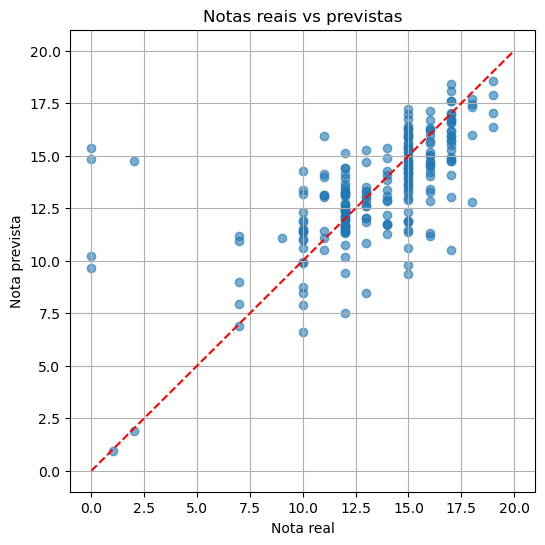

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([0, 20], [0, 20], 'r--')  # Linha ideal
plt.xlabel("Nota real")
plt.ylabel("Nota prevista")
plt.title("Notas reais vs previstas")
plt.grid(True)
plt.show()


vou testa-lo agora no testar_modelo.py

In [30]:
# Reaplicar stratificação
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from lightgbm import LGBMRegressor, early_stopping, log_evaluation

# Repetir divisão
stratifier = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
y_strat = stratifier.fit_transform(y.values.reshape(-1, 1)).ravel()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y_strat, random_state=42
)

# Atribuir pesos às faixas
bins = [0, 9, 13, 16, 18, 20]
labels = ["Muito baixa", "Baixa", "Média", "Alta", "Muito alta"]
y_train_bins = pd.cut(y_train, bins=bins, labels=labels)

pesos_por_faixa = {
    "Muito baixa": 5,
    "Baixa": 1,
    "Média": 1,
    "Alta": 2,
    "Muito alta": 5
}
sample_weights = y_train_bins.map(pesos_por_faixa)

# Treinar modelo final
modelo_final = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

modelo_final.fit(
    X_train, y_train,
    sample_weight=sample_weights,
    eval_set=[(X_test, y_test)],
    eval_metric="mae",
    callbacks=[
        early_stopping(stopping_rounds=30),
        log_evaluation(period=50)
    ]
)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 429
[LightGBM] [Info] Number of data points in the train set: 861, number of used features: 8
[LightGBM] [Info] Start training from score 12.886972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMRegressor(learning_rate=0.05, max_depth=6, n_estimators=1000,
              random_state=42)

In [31]:
import joblib
joblib.dump(modelo_final, "modelo_final_nota_aluno.pkl")


['modelo_final_nota_aluno.pkl']

In [32]:
df = pd.read_csv("student_features_interval_all.csv")
X_raw = df.drop(columns=["Final Grade"])
y = df["Final Grade"]
X = preprocess_data_for_prediction(X_raw)


Pré-processamento: Dimensões iniciais dos novos dados: (1077, 20)
Pré-processamento: Removendo colunas irrelevantes...
  Coluna 'project_id' removida.
  Coluna 'group_id' removida.
  Coluna 'mention_handle' removida.
  Coluna 'last_minute_commits' removida.
  Coluna 'sum_lines_per_commit' removida.
Pré-processamento: Dimensões após remoção inicial: (1077, 15)
Pré-processamento: Criando features _log diretas...
  Feature 'sum_lines_added_log' criada.
  Feature 'total_issues_created_log' criada.
  Feature 'issue_participation_log' criada.
Pré-processamento: Iniciando engenharia de features (ratios, combinadas)...
  Feature 'merged_ratio_log' criada.
  Feature 'issue_resolution_rate_created_log' criada.
  Feature 'total_review_activity_log' criada.
Pré-processamento: Selecionando e ordenando features finais...
Pré-processamento: Dimensões finais dos dados prontos para o modelo (antes do scaler): (1077, 8)


In [33]:
X['interval'].value_counts().sort_index()

interval
1    186
2    216
3    225
4    225
5    225
Name: count, dtype: int64

nesta estratégia vamos focar em cada um dos intervalos

--> primeiro intervalo:

In [9]:
df = pd.read_csv("student_features_interval_all.csv")
df_interval_1 = df[df["interval"] == 1].copy()

In [10]:
X_raw = df_interval_1.drop(columns=["Final Grade"])
y = df_interval_1["Final Grade"]

X = preprocess_data_for_prediction(X_raw)


Pré-processamento: Dimensões iniciais dos novos dados: (186, 20)
Pré-processamento: Removendo colunas irrelevantes...
  Coluna 'project_id' removida.
  Coluna 'group_id' removida.
  Coluna 'mention_handle' removida.
  Coluna 'last_minute_commits' removida.
  Coluna 'sum_lines_per_commit' removida.
Pré-processamento: Dimensões após remoção inicial: (186, 15)
Pré-processamento: Criando features _log diretas...
  Feature 'sum_lines_added_log' criada.
  Feature 'total_issues_created_log' criada.
  Feature 'issue_participation_log' criada.
Pré-processamento: Iniciando engenharia de features (ratios, combinadas)...
  Feature 'merged_ratio_log' criada.
  Feature 'issue_resolution_rate_created_log' criada.
  Feature 'total_review_activity_log' criada.
Pré-processamento: Selecionando e ordenando features finais...
Pré-processamento: Dimensões finais dos dados prontos para o modelo (antes do scaler): (186, 8)


!pip install lightgbm

In [ ]:
!pip install lightgbm

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from lightgbm import LGBMRegressor, early_stopping, log_evaluation

# Stratificação e divisão
stratifier = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
y_strat = stratifier.fit_transform(y.values.reshape(-1, 1)).ravel()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y_strat, random_state=42
)

# Atribuir pesos
bins = [0, 9, 13, 16, 18, 20]
labels = ["Muito baixa", "Baixa", "Média", "Alta", "Muito alta"]
y_train_bins = pd.cut(y_train, bins=bins, labels=labels)
pesos_por_faixa = {
    "Muito baixa": 5,
    "Baixa": 1,
    "Média": 1,
    "Alta": 2,
    "Muito alta": 5
}
sample_weights = y_train_bins.map(pesos_por_faixa)

# Treinar modelo
modelo_interval_1 = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

modelo_interval_1.fit(
    X_train, y_train,
    sample_weight=sample_weights,
    eval_set=[(X_test, y_test)],
    eval_metric="mae",
    callbacks=[
        early_stopping(stopping_rounds=30),
        log_evaluation(period=50)
    ]
)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 69
[LightGBM] [Info] Number of data points in the train set: 148, number of used features: 7
[LightGBM] [Info] Start training from score 13.472081
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

LGBMRegressor(learning_rate=0.05, max_depth=6, n_estimators=1000,
              random_state=42)

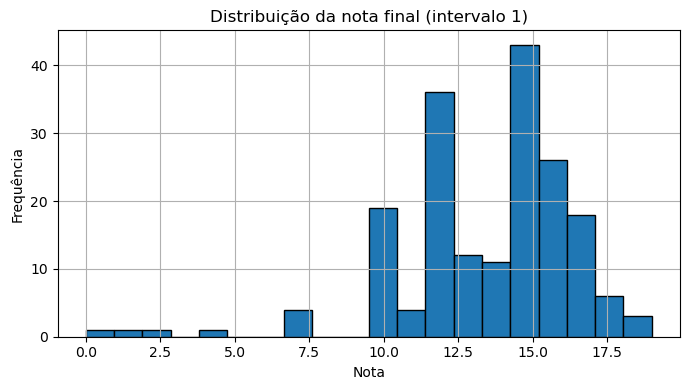

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
y.hist(bins=20, edgecolor='black')
plt.title("Distribuição da nota final (intervalo 1)")
plt.xlabel("Nota")
plt.ylabel("Frequência")
plt.grid(True)
plt.tight_layout()
plt.show()


In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Previsões
y_pred = modelo_interval_1.predict(X_test)

# Erros gerais
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nDesempenho para intervalo 1:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")



Desempenho para intervalo 1:
MAE: 2.25
RMSE: 2.83


In [39]:
bins = [0, 9, 13, 16, 18, 20]
labels = ["Muito baixa", "Baixa", "Média", "Alta", "Muito alta"]
y_test_bins = pd.cut(y_test, bins=bins, labels=labels)

results_df = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred,
    "faixa": y_test_bins
})

mae_por_faixa = results_df.groupby("faixa").apply(
    lambda g: mean_absolute_error(g["y_true"], g["y_pred"])
)
contagem_por_faixa = results_df["faixa"].value_counts().sort_index()

print("\n📊 MAE por faixa (intervalo 1):")
print(mae_por_faixa)

print("\n📊 Nº de exemplos por faixa:")
print(contagem_por_faixa)



📊 MAE por faixa (intervalo 1):
faixa
Muito baixa    7.074948
Baixa          1.795088
Média          1.756042
Alta           4.297563
Muito alta     4.377635
dtype: float64

📊 Nº de exemplos por faixa:
faixa
Muito baixa     2
Baixa          15
Média          18
Alta            2
Muito alta      1
Name: count, dtype: int64


C:\Users\cataf\AppData\Local\Temp\ipykernel_9932\2614321051.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mae_por_faixa = results_df.groupby("faixa").apply(
C:\Users\cataf\AppData\Local\Temp\ipykernel_9932\2614321051.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_por_faixa = results_df.groupby("faixa").apply(


In [40]:
importances = modelo_interval_1.feature_importances_
features = X.columns
sorted_idx = np.argsort(importances)[::-1]

print("\n📈 Importância das Features:")
for i in sorted_idx:
    print(f"{features[i]:<35} → {importances[i]}")



📈 Importância das Features:
total_review_activity_log           → 13
issue_participation_log             → 13
branches_created                    → 5
merged_ratio_log                    → 3
total_issues_created_log            → 3
interval                            → 0
sum_lines_added_log                 → 0
issue_resolution_rate_created_log   → 0


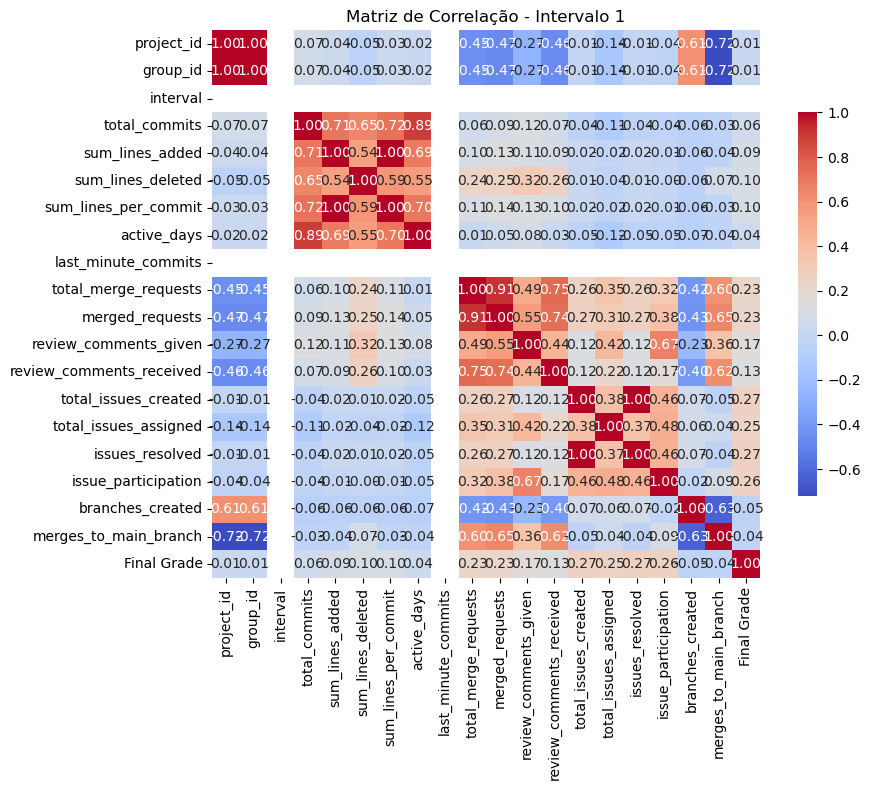

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Selecionar só colunas numéricas úteis para correlação
df_corr = df_interval_1.copy()

# Incluir a variável alvo
df_corr['Final Grade'] = y

# Matriz de correlação
corr_matrix = df_corr.corr(numeric_only=True)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={'shrink': 0.7})
plt.title("Matriz de Correlação - Intervalo 1")
plt.tight_layout()
plt.show()


---
novo pre processamento

In [20]:
FEATURES_INTERVALO_1_RELEVANTES = [
    "review_comments_given",
    "review_comments_received",
    "merged_requests",
    "total_merge_requests",
    "merges_to_main_branch",
    "total_issues_created",
    "issues_resolved"
]


In [21]:
def preprocess_interval_1(df_raw):
    df = df_raw.copy()
    EPSILON = 1e-6

    # Criar total_review_activity_log
    df["total_review_activity_log"] = np.log1p(
        df.get("review_comments_given", 0) + df.get("review_comments_received", 0)
    )

    # Criar issue_resolution_rate_log
    df["issue_resolution_rate_log"] = np.log1p(
        df.get("issues_resolved", 0) / (df.get("total_issues_created", 0) + EPSILON)
    )

    # Garantir todas as colunas estão presentes
    for col in FEATURES_INTERVALO_1_RELEVANTES:
        if col not in df:
            df[col] = 0

    # Final selection (e combinadas)
    final_cols = [
        "review_comments_given",
        "review_comments_received",
        "merged_requests",
        "total_merge_requests",
        "merges_to_main_branch",
        "total_issues_created",
        "issues_resolved",
        "total_review_activity_log",
        "issue_resolution_rate_log"
    ]
    return df[final_cols]


In [22]:
modelo_i1 = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

modelo_i1.fit(
    X_train, y_train,
    sample_weight=sample_weights,
    eval_set=[(X_test, y_test)],
    eval_metric="mae",
    callbacks=[
        early_stopping(stopping_rounds=30),
        log_evaluation(period=50)
    ]
)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 69
[LightGBM] [Info] Number of data points in the train set: 148, number of used features: 7
[LightGBM] [Info] Start training from score 13.472081
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

LGBMRegressor(learning_rate=0.05, max_depth=6, n_estimators=1000,
              random_state=42)

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prever
y_pred = modelo_i1.predict(X_test)

# Avaliação geral
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# MAE por faixa
y_test_bins = pd.cut(y_test, bins=bins, labels=labels)
results_df = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred,
    "faixa": y_test_bins
})
mae_faixa = results_df.groupby("faixa").apply(lambda g: mean_absolute_error(g["y_true"], g["y_pred"]))
print("\n📊 MAE por faixa:")
print(mae_faixa)


MAE: 2.25
RMSE: 2.83

📊 MAE por faixa:
faixa
Muito baixa    7.074948
Baixa          1.795088
Média          1.756042
Alta           4.297563
Muito alta     4.377635
dtype: float64


C:\Users\Miguel António\AppData\Local\Temp\ipykernel_7200\1463012697.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mae_faixa = results_df.groupby("faixa").apply(lambda g: mean_absolute_error(g["y_true"], g["y_pred"]))
C:\Users\Miguel António\AppData\Local\Temp\ipykernel_7200\1463012697.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_faixa = results_df.groupby("faixa").apply(lambda g: mean_absolute_error(g["y_true"], g["y_pred"]))


péssimo

In [26]:
FEATURES_HIBRIDO_INTERVALO_1 = [
    "review_comments_given",
    "review_comments_received",
    "total_review_activity_log",
    "merged_requests",
    "total_merge_requests",
    "merges_to_main_branch",
    "total_issues_created",
    "issues_resolved",
    "issue_resolution_rate_log",
    "sum_lines_added_log",
    "issue_participation_log",
    "branches_created"
]


In [27]:
def preprocess_interval_1_hibrido(df_raw):
    df = df_raw.copy()
    EPSILON = 1e-6

    # Total review activity
    df["total_review_activity_log"] = np.log1p(
        df.get("review_comments_given", 0) + df.get("review_comments_received", 0)
    )

    # Issue resolution rate
    df["issue_resolution_rate_log"] = np.log1p(
        df.get("issues_resolved", 0) / (df.get("total_issues_created", 0) + EPSILON)
    )

    # Log de linhas adicionadas
    df["sum_lines_added_log"] = np.log1p(df.get("sum_lines_added", 0))

    # Log de issue participation
    df["issue_participation_log"] = np.log1p(df.get("issue_participation", 0))

    # Garantir que todas as colunas estão presentes
    for col in FEATURES_HIBRIDO_INTERVALO_1:
        if col not in df:
            df[col] = 0

    return df[FEATURES_HIBRIDO_INTERVALO_1]


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np

# Carregar dados e filtrar por intervalo 1
df = pd.read_csv("student_features_interval_all.csv")
df_i1 = df[df["interval"] == 1].copy()
X_raw = df_i1.drop(columns=["Final Grade"])
y = df_i1["Final Grade"]

# Pré-processar com híbrido
X = preprocess_interval_1_hibrido(X_raw)

# Stratificação
stratifier = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
y_strat = stratifier.fit_transform(y.values.reshape(-1, 1)).ravel()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y_strat, random_state=42
)

# Pesos por faixa
bins = [0, 9, 13, 16, 18, 20]
labels = ["Muito baixa", "Baixa", "Média", "Alta", "Muito alta"]
y_train_bins = pd.cut(y_train, bins=bins, labels=labels)
pesos = {
    "Muito baixa": 5,
    "Baixa": 1,
    "Média": 1,
    "Alta": 2,
    "Muito alta": 5
}
sample_weights = y_train_bins.map(pesos)

# Treinar modelo
modelo_hibrido_i1 = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

modelo_hibrido_i1.fit(
    X_train, y_train,
    sample_weight=sample_weights,
    eval_set=[(X_test, y_test)],
    eval_metric="mae",
    callbacks=[
        early_stopping(stopping_rounds=30),
        log_evaluation(50)
    ]
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 117
[LightGBM] [Info] Number of data points in the train set: 148, number of used features: 12
[LightGBM] [Info] Start training from score 13.472081
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LGBMRegressor(learning_rate=0.05, max_depth=6, n_estimators=1000,
              random_state=42)

In [29]:
y_pred = modelo_hibrido_i1.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\n📊 Desempenho (Híbrido Intervalo 1):")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# MAE por faixa
y_test_bins = pd.cut(y_test, bins=bins, labels=labels)
results_df = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred,
    "faixa": y_test_bins
})
mae_faixa = results_df.groupby("faixa").apply(lambda g: mean_absolute_error(g["y_true"], g["y_pred"]))
print("\n📊 MAE por faixa:")
print(mae_faixa)



📊 Desempenho (Híbrido Intervalo 1):
MAE: 2.26
RMSE: 2.83

📊 MAE por faixa:
faixa
Muito baixa    6.992035
Baixa          1.848922
Média          1.730776
Alta           4.369299
Muito alta     4.275437
dtype: float64


C:\Users\Miguel António\AppData\Local\Temp\ipykernel_7200\2865510718.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mae_faixa = results_df.groupby("faixa").apply(lambda g: mean_absolute_error(g["y_true"], g["y_pred"]))
C:\Users\Miguel António\AppData\Local\Temp\ipykernel_7200\2865510718.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_faixa = results_df.groupby("faixa").apply(lambda g: mean_absolute_error(g["y_true"], g["y_pred"]))


In [30]:
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import make_scorer, mean_absolute_error
import pandas as pd
import numpy as np

# Pré-processamento híbrido
def preprocess_interval_1_hibrido(df_raw):
    df = df_raw.copy()
    EPSILON = 1e-6

    df["total_review_activity_log"] = np.log1p(
        df.get("review_comments_given", 0) + df.get("review_comments_received", 0)
    )
    df["issue_resolution_rate_log"] = np.log1p(
        df.get("issues_resolved", 0) / (df.get("total_issues_created", 0) + EPSILON)
    )
    df["sum_lines_added_log"] = np.log1p(df.get("sum_lines_added", 0))
    df["issue_participation_log"] = np.log1p(df.get("issue_participation", 0))

    final_cols = [
        "review_comments_given",
        "review_comments_received",
        "total_review_activity_log",
        "merged_requests",
        "total_merge_requests",
        "merges_to_main_branch",
        "total_issues_created",
        "issues_resolved",
        "issue_resolution_rate_log",
        "sum_lines_added_log",
        "issue_participation_log",
        "branches_created"
    ]

    for col in final_cols:
        if col not in df:
            df[col] = 0

    return df[final_cols]

# === Dados ===
df = pd.read_csv("student_features_interval_all.csv")
df_i1 = df[df["interval"] == 1].copy()
X_raw = df_i1.drop(columns=["Final Grade"])
y = df_i1["Final Grade"]
X = preprocess_interval_1_hibrido(X_raw)

# Estratificação por quantis da nota
stratifier = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
y_strat = stratifier.fit_transform(y.values.reshape(-1, 1)).ravel()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Modelos a testar
modelos = {
    "LightGBM": LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42),
    "HistGradientBoosting": HistGradientBoostingRegressor(max_iter=500, max_depth=6, random_state=42)
}


In [31]:

# Avaliação por CV
resultados = []
for nome, modelo in modelos.items():
    scores = cross_validate(
        modelo, X, y,
        cv=cv,
        scoring={'mae': make_scorer(mean_absolute_error)},
        return_train_score=False
    )
    resultados.append({
        "Modelo": nome,
        "MAE Médio (CV)": np.mean(scores['test_mae']),
        "MAE Std": np.std(scores['test_mae'])
    })

# Mostrar resultados
df_resultados = pd.DataFrame(resultados)
print(df_resultados)


c:\Users\Miguel António\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 148, number of used features: 12
[LightGBM] [Info] Start training from score 13.668919
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

c:\Users\Miguel António\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Miguel António\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


                 Modelo  MAE Médio (CV)   MAE Std
0              LightGBM        2.183329  0.270822
1         Random Forest        2.212674  0.250299
2  HistGradientBoosting        2.309446  0.314191


In [32]:

# Avaliação por CV
resultados = []
for nome, modelo in modelos.items():
    scores = cross_validate(
        modelo, X, y,
        cv=cv,
        scoring={'mae': make_scorer(mean_absolute_error)},
        return_train_score=False
    )
    resultados.append({
        "Modelo": nome,
        "MAE Médio (CV)": np.mean(scores['test_mae']),
        "MAE Std": np.std(scores['test_mae'])
    })

# Mostrar resultados
df_resultados = pd.DataFrame(resultados)
print(df_resultados)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 148, number of used features: 12
[LightGBM] [Info] Start training from score 13.668919
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

c:\Users\Miguel António\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Miguel António\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Miguel António\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


                 Modelo  MAE Médio (CV)   MAE Std
0              LightGBM        2.183329  0.270822
1         Random Forest        2.212674  0.250299
2  HistGradientBoosting        2.309446  0.314191


In [105]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor

# Param grid (ajustável)
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    'n_estimators': [300, 500, 800],
    'min_child_samples': [10, 20, 30],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

# CV com estratificação
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search
modelo_lgb = LGBMRegressor(random_state=42)
grid = GridSearchCV(
    estimator=modelo_lgb,
    param_grid=param_grid,
    cv=cv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2
)

grid.fit(X, y_strat)  # y_strat se estiveres a fazer classificação ou y para regressão direta

# Resultados
print("Melhores parâmetros:")
print(grid.best_params_)
print(f"Melhor MAE (CV): {-grid.best_score_:.4f}")


Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 129
[LightGBM] [Info] Number of data points in the train set: 186, number of used features: 12
[LightGBM] [Info] Start training from score 2.274194
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [33]:
from lightgbm import LGBMRegressor
import joblib

melhor_modelo = LGBMRegressor(
    colsample_bytree=0.7,
    learning_rate=0.01,
    max_depth=4,
    min_child_samples=10,
    n_estimators=500,
    reg_alpha=0.1,
    reg_lambda=0,
    subsample=0.7,
    random_state=42
)
melhor_modelo.fit(X, y)  # y sem strat

joblib.dump(melhor_modelo, "modelo_intervalo1.pkl")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 129
[LightGBM] [Info] Number of data points in the train set: 186, number of used features: 12
[LightGBM] [Info] Start training from score 13.672043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

['modelo_intervalo1.pkl']

No tentes ficaram todos com a mesma nota mais ou menos... diferenciavam-se centessimas apenas. Mas a "ordem" das notas estava boa até

Vamos para o 2o intervalo

In [34]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import make_scorer, mean_absolute_error
from lightgbm import LGBMRegressor
import pandas as pd
import numpy as np
import joblib

# === 1. Carregar dados e filtrar intervalo 2 ===
df = pd.read_csv("student_features_interval_all.csv")
df_i2 = df[df["interval"] == 2].copy()
X_raw = df_i2.drop(columns=["Final Grade"])
y = df_i2["Final Grade"]

# === 2. Aplicar preprocessamento híbrido (o mesmo do intervalo 1) ===
X = preprocess_interval_1_hibrido(X_raw)  # usa a mesma função já definida

# === 3. Stratified KFold com target binned ===
stratifier = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
y_strat = stratifier.fit_transform(y.values.reshape(-1, 1)).ravel()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# === 4. Definir param_grid ===
param_grid = {
    'learning_rate': [0.01, 0.05],
    'max_depth': [4, 6],
    'n_estimators': [500, 800],
    'min_child_samples': [10, 20],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

# === 5. GridSearch ===
modelo_lgb = LGBMRegressor(random_state=42)
grid = GridSearchCV(
    estimator=modelo_lgb,
    param_grid=param_grid,
    cv=cv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2
)

grid.fit(X, y)


Fitting 5 folds for each of 256 candidates, totalling 1280 fits


c:\Users\Miguel António\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 223
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 12
[LightGBM] [Info] Start training from score 13.527778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 1.0],
                         'learning_rate': [0.01, 0.05], 'max_depth': [4, 6],
                         'min_child_samples': [10, 20],
                         'n_estimators': [500, 800], 'reg_alpha': [0, 0.1],
                         'reg_lambda': [0, 0.1], 'subsample': [0.7, 1.0]},
             scoring='neg_mean_absolute_error', verbose=2)

In [35]:
# === 6. Guardar modelo ===
print("Melhores parâmetros:")
print(grid.best_params_)
print(f"Melhor MAE (CV): {-grid.best_score_:.4f}")

Melhores parâmetros:
{'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_samples': 10, 'n_estimators': 500, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.7}
Melhor MAE (CV): 1.8764


In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np

# Prever com o melhor modelo
y_pred = grid.best_estimator_.predict(X)

# Avaliação global
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"\n📊 Avaliação - Intervalo 2:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Avaliação por faixa
bins = [0, 9, 13, 16, 18, 20]
labels = ["Muito baixa", "Baixa", "Média", "Alta", "Muito alta"]
y_bins = pd.cut(y, bins=bins, labels=labels)

df_result = pd.DataFrame({
    "y_true": y,
    "y_pred": y_pred,
    "faixa": y_bins
})

mae_por_faixa = df_result.groupby("faixa").apply(
    lambda g: mean_absolute_error(g["y_true"], g["y_pred"])
)
contagem_por_faixa = df_result["faixa"].value_counts().sort_index()

print("\n📊 MAE por faixa:")
print(mae_por_faixa)
print("\n📊 Nº de exemplos por faixa:")
print(contagem_por_faixa)



📊 Avaliação - Intervalo 2:
MAE: 1.38
RMSE: 2.03

📊 MAE por faixa:
faixa
Muito baixa    5.193011
Baixa          1.145291
Média          1.126774
Alta           1.186994
Muito alta     1.283639
dtype: float64

📊 Nº de exemplos por faixa:
faixa
Muito baixa    10
Baixa          85
Média          92
Alta           25
Muito alta      3
Name: count, dtype: int64


C:\Users\Miguel António\AppData\Local\Temp\ipykernel_7200\1467546330.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mae_por_faixa = df_result.groupby("faixa").apply(
C:\Users\Miguel António\AppData\Local\Temp\ipykernel_7200\1467546330.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_por_faixa = df_result.groupby("faixa").apply(


Está mais ou menos, acho que temos potencialidade para melhor

In [37]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# === 1. Dados do intervalo 2
df = pd.read_csv("student_features_interval_all.csv")
df_i2 = df[df["interval"] == 2].copy()
X_raw = df_i2.drop(columns=["Final Grade"])
y = df_i2["Final Grade"]

# === 2. Pré-processamento híbrido
X = preprocess_interval_1_hibrido(X_raw)

# === 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === 4. Pesos: penalizar mais as notas baixas
sample_weights = y_train.apply(
    lambda nota: 5 if nota <= 10 else (2 if nota <= 13 else 1)
)

# === 5. Modelo com melhores parâmetros
modelo_focado_baixas = LGBMRegressor(
    colsample_bytree=1.0,
    learning_rate=0.01,
    max_depth=4,
    min_child_samples=10,
    n_estimators=500,
    reg_alpha=0,
    reg_lambda=0,
    subsample=0.7,
    random_state=42
)

modelo_focado_baixas.fit(
    X_train, y_train,
    sample_weight=sample_weights,
    eval_set=[(X_test, y_test)],
    eval_metric="mae",
    callbacks=[
        early_stopping(stopping_rounds=30),
        log_evaluation(50)
    ]
)

# === 6. Avaliação
y_pred = modelo_focado_baixas.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\n📊 Avaliação final:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# MAE por faixa
bins = [0, 9, 13, 16, 18, 20]
labels = ["Muito baixa", "Baixa", "Média", "Alta", "Muito alta"]
y_test_bins = pd.cut(y_test, bins=bins, labels=labels)

results_df = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred,
    "faixa": y_test_bins
})

mae_faixa = results_df.groupby("faixa").apply(lambda g: mean_absolute_error(g["y_true"], g["y_pred"]))
print("\n📊 MAE por faixa:")
print(mae_faixa)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 203
[LightGBM] [Info] Number of data points in the train set: 172, number of used features: 12
[LightGBM] [Info] Start training from score 11.703364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

C:\Users\Miguel António\AppData\Local\Temp\ipykernel_7200\1432747136.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mae_faixa = results_df.groupby("faixa").apply(lambda g: mean_absolute_error(g["y_true"], g["y_pred"]))


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

piorou!

In [38]:
joblib.dump(grid.best_estimator_, "modelo_intervalo2.pkl")

['modelo_intervalo2.pkl']

# intervalo 3

In [39]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import make_scorer, mean_absolute_error
import pandas as pd
import numpy as np
import joblib

# === 1. Carregar dados ===
df = pd.read_csv("student_features_interval_all.csv")
df_i3 = df[df["interval"] == 3].copy()
X_raw = df_i3.drop(columns=["Final Grade"])
y = df_i3["Final Grade"]

# === 2. Pré-processar com função híbrida ===
X = preprocess_interval_1_hibrido(X_raw)

# === 3. Stratified CV com bins
stratifier = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
y_strat = stratifier.fit_transform(y.values.reshape(-1, 1)).ravel()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# === 4. Definir param_grid
param_grid = {
    'learning_rate': [0.01, 0.05],
    'max_depth': [4, 6],
    'n_estimators': [500, 800],
    'min_child_samples': [10, 20],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

# === 5. GridSearch
modelo_base = LGBMRegressor(random_state=42)
grid = GridSearchCV(
    estimator=modelo_base,
    param_grid=param_grid,
    cv=cv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2
)

grid.fit(X, y)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


c:\Users\Miguel António\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 225, number of used features: 12
[LightGBM] [Info] Start training from score 13.395556
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 1.0],
                         'learning_rate': [0.01, 0.05], 'max_depth': [4, 6],
                         'min_child_samples': [10, 20],
                         'n_estimators': [500, 800], 'reg_alpha': [0, 0.1],
                         'reg_lambda': [0, 0.1], 'subsample': [0.7, 1.0]},
             scoring='neg_mean_absolute_error', verbose=2)

In [40]:
# === 6. Guardar modelo final
print("Melhores parâmetros:")
print(grid.best_params_)
print(f"Melhor MAE (CV): {-grid.best_score_:.4f}")

Melhores parâmetros:
{'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_samples': 20, 'n_estimators': 800, 'reg_alpha': 0.1, 'reg_lambda': 0, 'subsample': 0.7}
Melhor MAE (CV): 1.8084


In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# Previsões no conjunto total
y_pred = grid.best_estimator_.predict(X)

mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"\n📊 Avaliação final - Intervalo 3:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# MAE por faixa
bins = [0, 9, 13, 16, 18, 20]
labels = ["Muito baixa", "Baixa", "Média", "Alta", "Muito alta"]
y_bins = pd.cut(y, bins=bins, labels=labels)

df_result = pd.DataFrame({
    "y_true": y,
    "y_pred": y_pred,
    "faixa": y_bins
})

mae_faixa = df_result.groupby("faixa").apply(lambda g: mean_absolute_error(g["y_true"], g["y_pred"]))
contagem_faixa = df_result["faixa"].value_counts().sort_index()

print("\n📊 MAE por faixa:")
print(mae_faixa)
print("\n📊 Nº de exemplos por faixa:")
print(contagem_faixa)



📊 Avaliação final - Intervalo 3:
MAE: 1.17
RMSE: 1.69

📊 MAE por faixa:
faixa
Muito baixa    3.299127
Baixa          0.879825
Média          1.072127
Alta           1.076303
Muito alta     1.422653
dtype: float64

📊 Nº de exemplos por faixa:
faixa
Muito baixa    11
Baixa          91
Média          93
Alta           25
Muito alta      3
Name: count, dtype: int64


C:\Users\Miguel António\AppData\Local\Temp\ipykernel_7200\2238380438.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mae_faixa = df_result.groupby("faixa").apply(lambda g: mean_absolute_error(g["y_true"], g["y_pred"]))
C:\Users\Miguel António\AppData\Local\Temp\ipykernel_7200\2238380438.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_faixa = df_result.groupby("faixa").apply(lambda g: mean_absolute_error(g["y_true"], g["y_pred"]))


In [42]:
joblib.dump(grid.best_estimator_, "modelo_intervalo3.pkl")

['modelo_intervalo3.pkl']

# intervalo 4

In [43]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import make_scorer, mean_absolute_error
import pandas as pd
import numpy as np
import joblib

# === 1. Dados
df = pd.read_csv("student_features_interval_all.csv")
df_i4 = df[df["interval"] == 4].copy()
X_raw = df_i4.drop(columns=["Final Grade"])
y = df_i4["Final Grade"]

# === 2. Pré-processamento
X = preprocess_interval_1_hibrido(X_raw)

# === 3. Stratified CV
stratifier = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
y_strat = stratifier.fit_transform(y.values.reshape(-1, 1)).ravel()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# === 4. Grid Search
param_grid = {
    'learning_rate': [0.01, 0.05],
    'max_depth': [4, 6],
    'n_estimators': [500, 800],
    'min_child_samples': [10, 20],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

modelo_base = LGBMRegressor(random_state=42)
grid = GridSearchCV(
    estimator=modelo_base,
    param_grid=param_grid,
    cv=cv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2
)

grid.fit(X, y)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


c:\Users\Miguel António\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 371
[LightGBM] [Info] Number of data points in the train set: 225, number of used features: 12
[LightGBM] [Info] Start training from score 13.395556
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 1.0],
                         'learning_rate': [0.01, 0.05], 'max_depth': [4, 6],
                         'min_child_samples': [10, 20],
                         'n_estimators': [500, 800], 'reg_alpha': [0, 0.1],
                         'reg_lambda': [0, 0.1], 'subsample': [0.7, 1.0]},
             scoring='neg_mean_absolute_error', verbose=2)

In [44]:
# === 5. Guardar modelo
print("Melhores parâmetros:")
print(grid.best_params_)
print(f"Melhor MAE (CV): {-grid.best_score_:.4f}")

Melhores parâmetros:
{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_samples': 20, 'n_estimators': 500, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.7}
Melhor MAE (CV): 1.7065


In [45]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np

# Previsões
y_pred = grid.best_estimator_.predict(X)

# Erros globais
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"\n📊 Avaliação final - Intervalo 4:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# MAE por faixa
bins = [0, 9, 13, 16, 18, 20]
labels = ["Muito baixa", "Baixa", "Média", "Alta", "Muito alta"]
y_bins = pd.cut(y, bins=bins, labels=labels)

df_result = pd.DataFrame({
    "y_true": y,
    "y_pred": y_pred,
    "faixa": y_bins
})

mae_faixa = df_result.groupby("faixa").apply(lambda g: mean_absolute_error(g["y_true"], g["y_pred"]))
contagem_faixa = df_result["faixa"].value_counts().sort_index()

print("\n📊 MAE por faixa:")
print(mae_faixa)
print("\n📊 Nº de exemplos por faixa:")
print(contagem_faixa)



📊 Avaliação final - Intervalo 4:
MAE: 1.23
RMSE: 1.87

📊 MAE por faixa:
faixa
Muito baixa    3.758264
Baixa          0.901973
Média          1.108848
Alta           1.018701
Muito alta     1.714443
dtype: float64

📊 Nº de exemplos por faixa:
faixa
Muito baixa    11
Baixa          91
Média          93
Alta           25
Muito alta      3
Name: count, dtype: int64


C:\Users\Miguel António\AppData\Local\Temp\ipykernel_7200\147802821.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mae_faixa = df_result.groupby("faixa").apply(lambda g: mean_absolute_error(g["y_true"], g["y_pred"]))
C:\Users\Miguel António\AppData\Local\Temp\ipykernel_7200\147802821.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_faixa = df_result.groupby("faixa").apply(lambda g: mean_absolute_error(g["y_true"], g["y_pred"]))


In [46]:
joblib.dump(grid.best_estimator_, "modelo_intervalo4.pkl")

['modelo_intervalo4.pkl']

Ele já está a prever muito bem... mas o intervalo entre alunos é muito pequeno... demasiado! ou seja a ordem está mais ou menos bem mas o "espalhamento" não

# intervalo 5

In [47]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import make_scorer, mean_absolute_error
import pandas as pd
import numpy as np
import joblib

# === 1. Dados do intervalo 5
df = pd.read_csv("student_features_interval_all.csv")
df_i5 = df[df["interval"] == 5].copy()
X_raw = df_i5.drop(columns=["Final Grade"])
y = df_i5["Final Grade"]

# === 2. Pré-processar
X = preprocess_interval_1_hibrido(X_raw)

# === 3. Stratified CV
stratifier = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
y_strat = stratifier.fit_transform(y.values.reshape(-1, 1)).ravel()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# === 4. Grid Search
param_grid = {
    'learning_rate': [0.01, 0.05],
    'max_depth': [4, 6],
    'n_estimators': [500, 800],
    'min_child_samples': [10, 20],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

modelo_base = LGBMRegressor(random_state=42)
grid = GridSearchCV(
    estimator=modelo_base,
    param_grid=param_grid,
    cv=cv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2
)

grid.fit(X, y)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


c:\Users\Miguel António\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 396
[LightGBM] [Info] Number of data points in the train set: 225, number of used features: 12
[LightGBM] [Info] Start training from score 13.395556
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 1.0],
                         'learning_rate': [0.01, 0.05], 'max_depth': [4, 6],
                         'min_child_samples': [10, 20],
                         'n_estimators': [500, 800], 'reg_alpha': [0, 0.1],
                         'reg_lambda': [0, 0.1], 'subsample': [0.7, 1.0]},
             scoring='neg_mean_absolute_error', verbose=2)

In [48]:
# === 5. Guardar o melhor modelo
print("Melhores parâmetros:")
print(grid.best_params_)
print(f"Melhor MAE (CV): {-grid.best_score_:.4f}")

Melhores parâmetros:
{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_samples': 20, 'n_estimators': 500, 'reg_alpha': 0.1, 'reg_lambda': 0, 'subsample': 0.7}
Melhor MAE (CV): 1.7463


In [49]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# Previsões
y_pred = grid.best_estimator_.predict(X)

# Erros globais
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"\n📊 Avaliação final - Intervalo 5:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# MAE por faixa
bins = [0, 9, 13, 16, 18, 20]
labels = ["Muito baixa", "Baixa", "Média", "Alta", "Muito alta"]
y_bins = pd.cut(y, bins=bins, labels=labels)

df_result = pd.DataFrame({
    "y_true": y,
    "y_pred": y_pred,
    "faixa": y_bins
})

mae_faixa = df_result.groupby("faixa").apply(lambda g: mean_absolute_error(g["y_true"], g["y_pred"]))
contagem_faixa = df_result["faixa"].value_counts().sort_index()

print("\n📊 MAE por faixa:")
print(mae_faixa)
print("\n📊 Nº de exemplos por faixa:")
print(contagem_faixa)



📊 Avaliação final - Intervalo 5:
MAE: 1.27
RMSE: 1.95

📊 MAE por faixa:
faixa
Muito baixa    3.951365
Baixa          0.861958
Média          1.203858
Alta           1.063885
Muito alta     2.143357
dtype: float64

📊 Nº de exemplos por faixa:
faixa
Muito baixa    11
Baixa          91
Média          93
Alta           25
Muito alta      3
Name: count, dtype: int64


C:\Users\Miguel António\AppData\Local\Temp\ipykernel_7200\1523936189.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mae_faixa = df_result.groupby("faixa").apply(lambda g: mean_absolute_error(g["y_true"], g["y_pred"]))
C:\Users\Miguel António\AppData\Local\Temp\ipykernel_7200\1523936189.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_faixa = df_result.groupby("faixa").apply(lambda g: mean_absolute_error(g["y_true"], g["y_pred"]))


In [50]:
joblib.dump(grid.best_estimator_, "modelo_intervalo5.pkl")

['modelo_intervalo5.pkl']